In [11]:
import numpy as np

N_SAMPLES = int(10**2)
RANDOM_SEED = 42

rng = np.random.RandomState(RANDOM_SEED)

In [12]:
from sklearn.datasets import make_classification

def generate_data(num_samples, prevalence=0.5, sensitive_prevalence=0.1, random_seed=42):
    
    # Generate features and labels with scikit-learn
    X, Y = make_classification(num_samples, weights=(1-prevalence, prevalence), random_state=random_seed)
    
    # Sensitive attrs
    rng = np.random.RandomState(random_seed)
    S = (rng.random(num_samples) + sensitive_prevalence).astype(int)

    return X, Y, S

In [13]:
X, Y, S = generate_data(num_samples=N_SAMPLES, random_seed=rng.randint(10**10))

In [14]:
# Split train, test
test_size = 0.2

indices = rng.permutation(N_SAMPLES)
test_indices = indices[: int(test_size * N_SAMPLES)]
train_indices = indices[int(test_size * N_SAMPLES): ]

X_train, y_train, s_train = X[train_indices], Y[train_indices], S[train_indices]
X_test, y_test, s_test = X[test_indices], Y[test_indices], S[test_indices]

# Use hpt package to train models

In [15]:
from pathlib import Path
HYPERPARAM_SPACE_PATH = Path() / 'hyperparameter_spaces'
HYPERPARAM_SPACE_PATH = HYPERPARAM_SPACE_PATH / 'sklearn.multiple_algorithms.yaml'

In [16]:
from hpt.tuner import ObjectiveFunction, OptunaTuner

obj_func = ObjectiveFunction(
    X_train, y_train, X_test, y_test,
    hyperparameter_space=HYPERPARAM_SPACE_PATH,
    eval_metric='accuracy',
    s_train=s_train,
    s_val=s_test,
    tpr=0.50,
    #threshold=0.50,
)

tuner = OptunaTuner(obj_func) # NOTE: can pass other useful study kwargs here (e.g. storage)

[I 2022-11-30 13:07:46,494] A new study created in memory with name: no-name-1e32ac73-b846-4b53-9018-2478c851214c


In [17]:
%%time
tuner.optimize(n_trials=10) #, show_progress_bar=True, n_jobs=4)

> /Users/acruz/Documents/hpt/src/hpt/evaluation.py(232)compute_binary_predictions()
    231     # TODO: https://github.com/AndreFCruz/hpt/issues/1
--> 232     y_pred_binary = (y_pred_scores >= threshold).astype(int)
    233 

ipdb> n
> /Users/acruz/Documents/hpt/src/hpt/evaluation.py(235)compute_binary_predictions()
    234     # 1. compute actual number of positive predictions (on relevant target samples)
--> 235     actual_pos_preds = np.sum(y_pred_binary[target_samples_indices])
    236 

ipdb> n
> /Users/acruz/Documents/hpt/src/hpt/evaluation.py(238)compute_binary_predictions()
    237     # 2. check if this number corresponds to the target
--> 238     if actual_pos_preds != positive_preds_budget:
    239         logging.warning(

ipdb> n
> /Users/acruz/Documents/hpt/src/hpt/evaluation.py(239)compute_binary_predictions()
    238     if actual_pos_preds != positive_preds_budget:
--> 239         logging.warning(
    240             "Target metric for thresholding could not be met, wi

> /Users/acruz/Documents/hpt/src/hpt/evaluation.py(244)compute_binary_predictions()
    243 
--> 244         assert actual_pos_preds > positive_preds_budget, (
    245             "Sanity check: actual number of positive predictions should always "

ipdb> n
> /Users/acruz/Documents/hpt/src/hpt/evaluation.py(251)compute_binary_predictions()
    250         # 2.1. if target was not met, compute number of extra predicted positives
--> 251         extra_pos_preds = actual_pos_preds - positive_preds_budget
    252 

ipdb> n
> /Users/acruz/Documents/hpt/src/hpt/evaluation.py(255)compute_binary_predictions()
    254         # samples (either TPs or FPs or PPs) with the same score
--> 255         rng = np.random.RandomState(random_seed)
    256 

ipdb> extra_pos_preds
6
ipdb> n
> /Users/acruz/Documents/hpt/src/hpt/evaluation.py(257)compute_binary_predictions()
    256 
--> 257         samples_at_target_threshold_mask = (y_pred_scores[y_pred_sorted_indices] == threshold)
    258 

ipdb> n
> /Us

ipdb> extra_pos_preds_indices
array([18,  2, 16,  4, 11, 14])
ipdb> y_pred_binary
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
ipdb> n
> /Users/acruz/Documents/hpt/src/hpt/evaluation.py(279)compute_binary_predictions()
    278     # Sanity check: the number of positive_preds_budget should now be exactly fulfilled
--> 279     assert np.sum(y_pred_binary[target_samples_indices]) == positive_preds_budget
    280 

ipdb> y_pred_binary
array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1])
ipdb> n
> /Users/acruz/Documents/hpt/src/hpt/evaluation.py(281)compute_binary_predictions()
    280 
--> 281     return y_pred_binary
    282 

ipdb> c


[W 2022-11-30 13:10:59,998] Trial 0 failed because of the following error: ValueError('not enough values to unpack (expected 4, got 1)')
Traceback (most recent call last):
  File "/Users/acruz/opt/miniconda3/envs/py3.8-hpt/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/Users/acruz/Documents/hpt/src/hpt/tuner.py", line 210, in __call__
    val_results = self.eval_func(
  File "/Users/acruz/Documents/hpt/src/hpt/tuner.py", line 84, in evaluate_predictions
    results.update(evaluate_fairness(
  File "/Users/acruz/Documents/hpt/src/hpt/evaluation.py", line 113, in evaluate_fairness
    curr_group_metrics = evaluate_performance(group_labels, group_preds)
  File "/Users/acruz/Documents/hpt/src/hpt/evaluation.py", line 31, in evaluate_performance
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
ValueError: not enough values to unpack (expected 4, got 1)


ValueError: not enough values to unpack (expected 4, got 1)

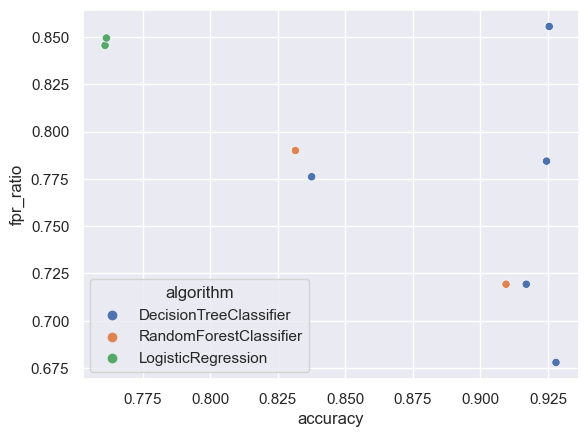

In [8]:
tuner.objective_function.plot(y_axis="fpr_ratio", pyplot_show=False, hue="algorithm")